In [1]:
%pip install -U "geemap[workshop]"

Note: you may need to restart the kernel to use updated packages.


In [2]:
import ee
import geemap
import geemap.colormaps as cm
from geemap import geojson_to_ee, ee_to_geojson

In [3]:
ee.Authenticate()
ee.Initialize()

In [4]:
import json

# City Municipal Districs
with open("./mo.geojson") as file:
    districts = geojson_to_ee(json.load(file))

In [5]:
def ndvi(img: ee.Image):
    ndvi = img.normalizedDifference(["B5", "B4"]).rename("NDVI")
    return img.addBands(ndvi)

collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA')

In [9]:
years = range(2021, 2025)
summers = [[f"{year}-06-01", f"{year}-08-31"] for year in years]
filters = [ee.Filter.date(*summer) for summer in summers]
allSeasonsFilter = ee.Filter.Or(filters)

In [30]:
# Number of images

def add_year(img: ee.Image):
    date = ee.Date(img.get("DATE_ACQUIRED"))
    return img.set("YEAR", date.get("year"))

images = collection.filterBounds(districts.geometry()) \
    .filter(allSeasonsFilter) \
    .filter(ee.Filter.lt("CLOUD_COVER", 10)) \
    .map(ndvi) \
    .select(['B2','B3','B4','B5','NDVI']) \
    .map(add_year)

print(images.size().getInfo())

23


<Axes: xlabel='year'>

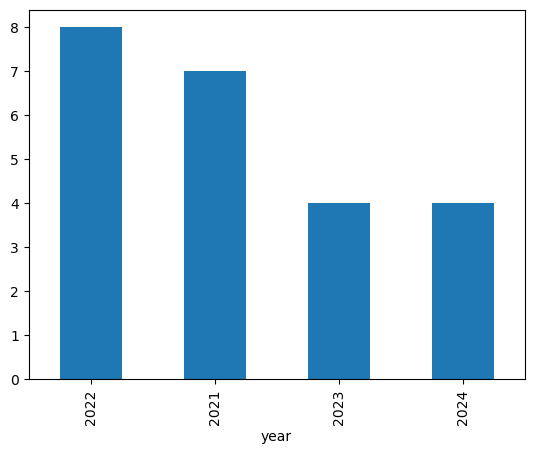

In [ ]:
import pandas as pd

year_acquired=images.aggregate_array("YEAR").getInfo()
year_acquired = pd.DataFrame(year_acquired, columns=["year"])
year_acquired["year"].value_counts().plot(kind='bar')

In [6]:
# years = range(2019, 2025)
years = [2019, 2024]
images = {}
for year in years:
    summer = [f"{year}-06-01", f"{year}-08-31"]
    filter = ee.Filter.date(*summer)
    seasonCollection = collection.filterBounds(districts.geometry()) \
        .filter(filter) \
        .filter(ee.Filter.lt("CLOUD_COVER", 4)) \
        .select(['B2','B3','B4','B5']) \
        

    print(f"{year} : {seasonCollection.size().getInfo()}")
    min_image = seasonCollection.min()
    ndvi = min_image.normalizedDifference(['B5', 'B4']).rename('NDVI')
    image = min_image.addBands(ndvi)
    images.update({year: image})

    districts = image.select(['NDVI']) \
        .reduceRegions(
            collection = districts,
            reducer=ee.Reducer.mean().setOutputs([f"{year}"]),
            scale=30,
            crs='EPSG:4326'
        )



2019 : 2
2024 : 3


In [18]:
name_first = f"NDVI{years[0]}"
name_last = f"NDVI{years[-1]}"
ndvi_first = images[years[0]].select(['NDVI']).rename(name_first)
ndvi_last = images[years[-1]].select(['NDVI']).rename(name_last)
ndvi_image = ee.Image.cat(ndvi_first, ndvi_last)
ndvi_diff = ndvi_image.expression(f'b("{name_last}")-b("{name_first}")').rename('DIFF')
ndvi_diff_per = ndvi_image.expression(f'(b("{name_last}")-b("{name_first}"))/((b("{name_last}")+b("{name_first}"))/2)').rename('DIFF_PER')
ndvi_image = ee.Image.cat(ndvi_image, ndvi_diff, ndvi_diff_per)

districts = ndvi_image.select(['DIFF']) \
    .reduceRegions(
        collection = districts,
        reducer=ee.Reducer.mean().setOutputs([f"NDVI_DIFF"]),
        scale=30,
        crs='EPSG:4326'
    )

ndvi_image.bandNames().getInfo()

['NDVI2019', 'NDVI2024', 'DIFF', 'DIFF_PER']

In [19]:
rgb_vis = {"bands": ["B4", "B3", "B2"], "min": 0, "max": 0.3}
change_vis = {"min": -1, "max": 1, "palette": ["red", "white", "green"]}
ndvi_vis = {"bands": ["NDVI"], "min": 0, "max": 1, "palette": cm.palettes.ndvi}

map = geemap.Map(center=[55.71782880151228, 37.62268066406251], zoom=8, height=1000)

for year, image in images.items():
    map.addLayer(image, rgb_vis, f"{year}")
    
for year, image in images.items():
    map.addLayer(image, ndvi_vis, f"{year} NDVI")

map.addLayer(ndvi_image, {"bands": ["DIFF"], **change_vis}, f"NDVI DIFF")
map.addLayer(ndvi_image, {"bands": ["DIFF_PER"], **change_vis}, f"NDVI DIFF (%)")
map.addLayer(districts.style(**{'color': '808080', 'width': 0.5, 'fillColor': '00000000'}), {}, "Moscow Districts")
map

Map(center=[55.71782880151228, 37.62268066406251], controls=(WidgetControl(options=['position', 'transparent_b…

In [17]:
gdf = geemap.ee_to_gdf(districts)
gdf = gdf.sort_values(by='NDVI_DIFF').reset_index(drop=True)
print(gdf[['NAME', 'NAME_AO', 'NDVI_DIFF']].to_markdown())


|     | NAME                      | NAME_AO          |    NDVI_DIFF |
|----:|:--------------------------|:-----------------|-------------:|
|   0 | Кокошкино                 | Новомосковский   | -0.0444266   |
|   1 | Печатники                 | Юго-Восточный    | -0.0356035   |
|   2 | Десёновское               | Новомосковский   | -0.034407    |
|   3 | "Мосрентген"              | Новомосковский   | -0.0320654   |
|   4 | Краснопахорское           | Троицкий         | -0.0309072   |
|   5 | Троицк                    | Троицкий         | -0.0266794   |
|   6 | Царицыно                  | Южный            | -0.0231389   |
|   7 | Марушкинское              | Новомосковский   | -0.0200405   |
|   8 | Новофёдоровское           | Троицкий         | -0.0185155   |
|   9 | Нагатинский Затон         | Южный            | -0.0180237   |
|  10 | Кунцево                   | Западный         | -0.0174779   |
|  11 | Хорошёво-Мнёвники         | Северо-Западный  | -0.0174069   |
|  12 | Беговой     

In [ ]:
projection = ndvi_image.select('DIFF').projection().getInfo()
task = ee.batch.Export.image.toDrive(
    image=ndvi_image,
    description=f'NDVI-{years[0]}-{years[-1]}',
    scale=30, 
    crs='EPSG:4326',
    maxPixels = 892227573612
)
task.start()

In [69]:
print(task.status())

{'state': 'RUNNING', 'description': 'imageToDriveExample_transform', 'priority': 100, 'creation_timestamp_ms': 1746603198594, 'update_timestamp_ms': 1746604647800, 'start_timestamp_ms': 1746603203924, 'task_type': 'EXPORT_IMAGE', 'attempt': 1, 'batch_eecu_usage_seconds': 136948.38, 'id': 'X2LFW34WHALZNHSLO4EZAHCO', 'name': 'projects/90917923301/operations/X2LFW34WHALZNHSLO4EZAHCO'}


In [39]:
summer = [f"{2024}-06-01", f"{2024}-08-31"]
filter = ee.Filter.date(*summer)
seasonCollection = collection.filterBounds(districts.geometry()) \
    .filter(filter) \
    .filter(ee.Filter.lt("CLOUD_COVER", 4)) \
    .select(['B2','B3','B4','B5']) \
    
seasonCollection.first().getInfo()


# ndvi_images = ee.ImageCollection([ndvi_image])
# geemap.download_ee_image_collection(ndvi_images, '.',  scale=30, crs='EPSG:4326')

{'type': 'Image',
 'bands': [{'id': 'B2',
   'data_type': {'type': 'PixelType', 'precision': 'float'},
   'dimensions': [7991, 8071],
   'crs': 'EPSG:32637',
   'crs_transform': [30, 0, 419685, 0, -30, 6316815]},
  {'id': 'B3',
   'data_type': {'type': 'PixelType', 'precision': 'float'},
   'dimensions': [7991, 8071],
   'crs': 'EPSG:32637',
   'crs_transform': [30, 0, 419685, 0, -30, 6316815]},
  {'id': 'B4',
   'data_type': {'type': 'PixelType', 'precision': 'float'},
   'dimensions': [7991, 8071],
   'crs': 'EPSG:32637',
   'crs_transform': [30, 0, 419685, 0, -30, 6316815]},
  {'id': 'B5',
   'data_type': {'type': 'PixelType', 'precision': 'float'},
   'dimensions': [7991, 8071],
   'crs': 'EPSG:32637',
   'crs_transform': [30, 0, 419685, 0, -30, 6316815]}],
 'version': 1746564941747523,
 'id': 'LANDSAT/LC08/C02/T1_TOA/LC08_177021_20240707',
 'properties': {'RADIANCE_MULT_BAND_5': 0.0059145,
  'RADIANCE_MULT_BAND_6': 0.0014709,
  'RADIANCE_MULT_BAND_3': 0.011462,
  'RADIANCE_MULT_BA